In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [264]:
df = pd.read_csv("./data/protein_data raw.csv", index_col=0)
# df_esm = pd.read_parquet("./data/streptavidin-esm2-karim.parquet")

df["Plate"] = df["Plate"].str.replace("Plate_", "").astype(int)
print(df.head())
#unique values in each column
print(df.nunique())

    Fitness  Fitness_raw  Plate Position  \
0  0.043099     0.000036      1      A 2   
1  0.018953     0.000016      1      A 4   
2  0.010879     0.000009      1      A 5   
3 -0.011885    -0.000010      1      A 6   
4  0.663526     0.000548      1      A 8   

                                             variant  Reads  
0  AEAAQSVDQLFKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWT...     30  
1  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     26  
2  AEAAQSVDQLIKARGMVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     90  
3  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWN...    142  
4  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     66  
Fitness        1034
Fitness_raw    1034
Plate            20
Position         93
variant         524
Reads           352
dtype: int64


In [265]:
# Assuming df["variant"] is a list or Series of sequences
sequences = df["variant"]

# Find positions where at least one sequence differs
different_positions = set()
for i in range(len(sequences[0])):  # Loop over character positions
    column_chars = {seq[i] for seq in sequences}  # Collect characters at this position
    if len(column_chars) > 1:  # Check if there's a difference
        different_positions.add(i)

set_mutants_pos = sorted(different_positions)

df["mutant"] = df["variant"].apply(lambda x: "".join([x[i] for i in set_mutants_pos]))

df.nunique()


WT = df["mutant"].value_counts().index[0]


array([[<Axes: title={'center': 'Fitness'}>,
        <Axes: title={'center': 'Fitness_raw'}>],
       [<Axes: title={'center': 'Plate'}>,
        <Axes: title={'center': 'Reads'}>]], dtype=object)

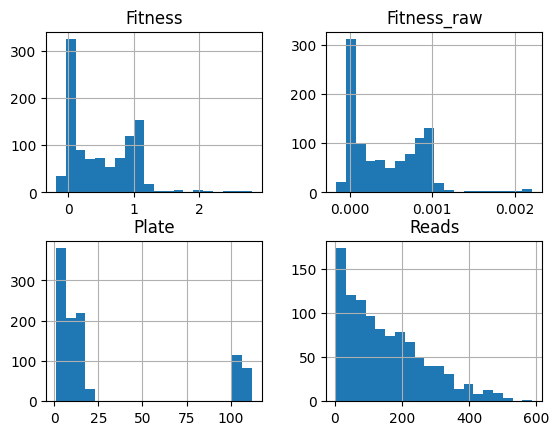

In [266]:
# histogram of all numerial columns 3 columns in plot
df.hist(bins=20)

mutant
DIARKVYFATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQQGGGMLWHSQSKTTNMKNTTRGKAWDGEAEGRQTNEDYIPQNAKYIMDYDSPQNRKQWRAGGSQTHSGAGVQAPLSTPESILMLDAGASPTYVNVNANQSTVFGVPDWRTTPGFPYNIQDGSG    0.000033
DIARKVYPATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQQGGGMLWHSQSKTTNMKNTTRGKAWDGEAEGRQTNEDYIPQNAKYIMDYDSPQNRKQWRAGGSQTHSGAGVQAPLSTPESILMLDAGASPTYVNVNANQSTVFGVPDWRTTPGFPYNIQDGSG    0.000015
DIARKVYQATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQQGGGMLWHSQSKTTNMKNTTRGKAWDGEAEGRQTNEDYIPQNAKYIMDYDSPQNRKQWRAGGSQTHSGAGVQAPLSTPESILMLDAGASPTYVNVNANQSTVFGVPDWRTTPGFPYNIQDGSG    0.000034
DIARKVYVAQQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQQGGGMLWHSQSKTTNMKNTTRGKAWDGEAEGRQTNEDYIPQNAKYIMDYDSPQNRKQWRAGGSQTHSGAGVQAPLSTPESILMLDAGASPTYVNVNANQSTVFGVPDWRTTPGFPYNIQDGSG    0.000042
DIARKVYVATINRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQQGGGMLWHSQSKTTNMKNTTRGKAWDGEAEGRQTNEDYIPQNAKYIMDYDSPQNRKQWRAGGSQTHSGAGVQAPLSTPESILMLDAGASPTYVNVNANQSTVFGVPDWRTTPGFPYNIQDGSG    0.000006
                                                                                   

<Axes: title={'center': 'Relative standard deviation'}, xlabel='mutant'>

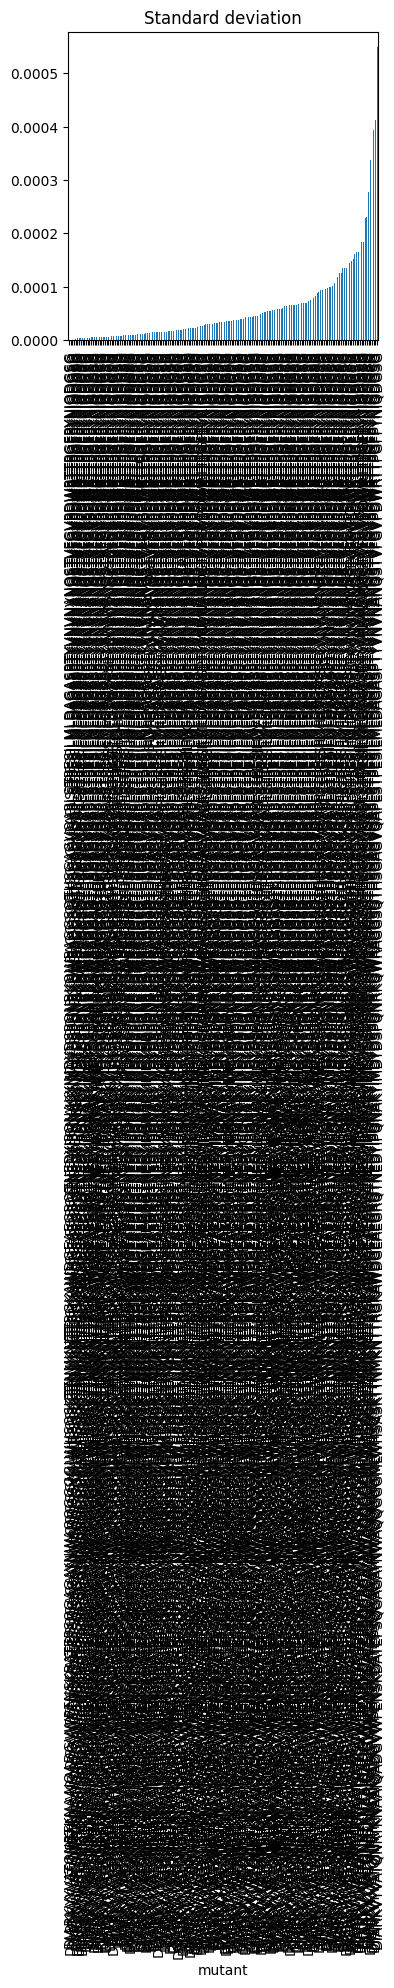

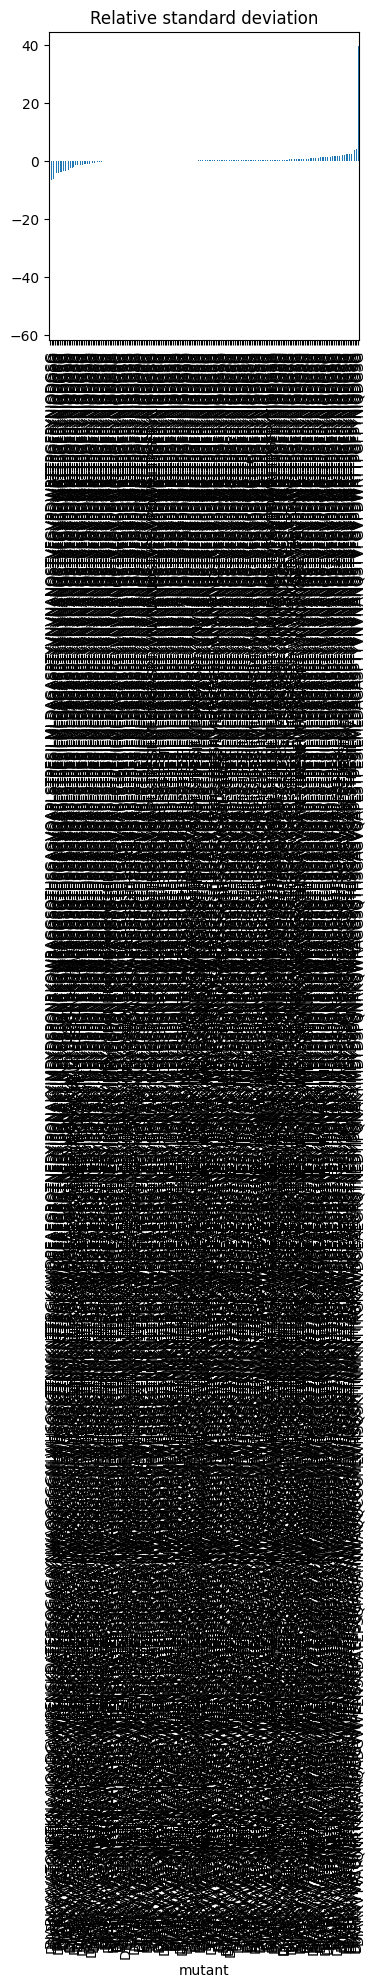

In [267]:
metric = 'Fitness_raw'

stds = df.groupby('mutant')[metric].std()
has_std = ~stds.isna()
stds[has_std]
print(stds[has_std])

means = df.groupby('mutant')[metric].mean()[has_std]

fig = plt.figure(figsize=(4, 4))
stds[has_std].sort_values().plot(kind='bar', title='Standard deviation')

fig = plt.figure(figsize=(4, 4))
rel_std = stds[has_std] / means
rel_std.sort_values().plot(kind='bar', title='Relative standard deviation')

In [268]:
df.columns

Index(['Fitness', 'Fitness_raw', 'Plate', 'Position', 'variant', 'Reads',
       'mutant'],
      dtype='object')

3.5 5.5


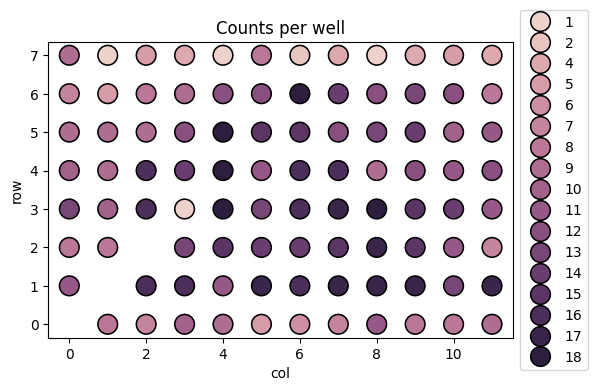

In [288]:
#convert well to row and column eg E4 -> 5, 4

def well_to_row_col(well):
    well = well.replace(' ', '')
    row = ord(well[0]) - ord('A')
    col = int(well[1:]) - 1
    return row, col

df['row'], df['col'] = zip(*df['Position'].map(well_to_row_col))

#add little bit of noise to row and col
# df['row'] += np.random.normal(0, 0.1, size=len(df))
# df['col'] += np.random.normal(0, 0.1, size=len(df))


center_row = df['row'].unique().mean()
center_col = df['col'].unique().mean()
print(center_row, center_col)

df['crow'] = df['row'] - center_row
df['ccol'] = df['col'] - center_col

# df['dist'] = np.sqrt(df['crow']**2 + df['ccol']**2)
#manhattan distance
df['dist'] = np.abs(df['crow']) + np.abs(df['ccol'])

#dist_c_row
df['dist_c_row'] = np.abs(df['crow'])
#dist_c_col
df['dist_c_col'] = np.abs(df['ccol'])

df["border"] = (df["dist_c_row"] > 3 ) | ( df["dist_c_col"] > 5)
fig = plt.figure(figsize=(4, 4))

df_pl = df.select_dtypes(include=[np.number]).copy()
df_c = df_pl.groupby(['row', 'col']).count().reset_index()
sns.scatterplot(x='col', y='row', hue=metric, data=df_c, s=200, edgecolor='black', legend="full")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#title
plt.title('Counts per well')
# bigger
plt.gcf().set_size_inches(6, 6)


In [ ]:
df[(df["row"] == 7) & (df["col"] == 6)]

Fitness  Fitness_raw  Plate Position  \
143 -0.007122    -0.000006      2      H 7   
983  0.018758     0.000019     16      H 7   

                                               variant  Reads  \
143  AEAAQSVDQLIKARGKVYFGVWTDQNRLTTGKNAAIIQADFGMVWP...     44   
983  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...    196   

                                                mutant  row  col  crow  ccol  \
143  DIARKVYVWTQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQ...    7    6   3.5   0.5   
983  DIARKVYVATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQ...    7    6   3.5   0.5   

     dist  dist_c_row  dist_c_col  border  
143   4.0         3.5         0.5    True  
983   4.0         3.5         0.5    True

In [272]:
df

Fitness  Fitness_raw  Plate Position  \
0     0.043099     0.000036      1      A 2   
1     0.018953     0.000016      1      A 4   
2     0.010879     0.000009      1      A 5   
3    -0.011885    -0.000010      1      A 6   
4     0.663526     0.000548      1      A 8   
...        ...          ...    ...      ...   
1032  0.027456     0.000027     18      G 5   
1033  0.982857     0.000975     18      G 8   
1034  0.048359     0.000048     18     G 10   
1035  0.619423     0.000615     18     G 11   
1036  0.055539     0.000055     18     H 10   

                                                variant  Reads  \
0     AEAAQSVDQLFKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWT...     30   
1     AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     26   
2     AEAAQSVDQLIKARGMVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     90   
3     AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWN...    142   
4     AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     66   
...                                                 ...    ...   
1032  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...    123   
1033  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...    190   
1034  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     75   
1035  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     69   
1036  AEAAQSVDQLIKARGKVYFGVATDQNRLTTGKNAAIIQADFGMVWP...     58   

                                                 mutant  row  col  crow  ccol  \
0     DFARKVYVATQNRTKNAAIQADGVWTENSKDATEPSQGAGAYNWAQ...    0    1  -3.5  -4.5   
1     DIARKVYVATQNRTKNAAIQADGVWPGNSKDATEPSQGAGAYNWAQ...    0    3  -3.5  -2.5   
2     DIARMVYVATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQ...    0    4  -3.5  -1.5   
3     DIARKVYVATQNRTKNAAIQADGVWNENSKDATEPSQGAGAYNWAQ...    0    5  -3.5  -0.5   
4     DIARKVYVATQNRTKNAAIQADGVWPLNSKDATEPSQGAGAYNWAQ...    0    7  -3.5   1.5   
...                                                 ...  ...  ...   ...   ...   
1032  DIARKVYVATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQ...    6    4   2.5  -1.5   
1033  DIARKVYVATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQ...    6    7   2.5   1.5   
1034  DIARKVYVATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQ...    6    9   2.5   3.5   
1035  DIARKVYVATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQ...    6   10   2.5   4.5   
1036  DIARKVYVATQNRTKNAAIQADGVWPENSKDATEPSQGAGAYNWAQ...    7    9   3.5   3.5   

      dist  dist_c_row  dist_c_col  border  
0      8.0         3.5         4.5    True  
1      6.0         3.5         2.5    True  
2      5.0         3.5         1.5    True  
3      4.0         3.5         0.5    True  
4      5.0         3.5         1.5    True  
...    ...         ...         ...     ...  
1032   4.0         2.5         1.5   False  
1033   4.0         2.5         1.5   False  
1034   6.0         2.5         3.5   False  
1035   7.0         2.5         4.5   False  
1036   7.0         3.5         3.5    True  

[1034 rows x 15 columns]

In [273]:
df.columns
# ['well', 'indole', 'OD', 'plate_library', 'variant', 'norm_TSNAK', '_id',
#        'embedding-mean', 'identifier', 'params', 'seq', 'status', 'timestamp',
#        'y', 'row', 'col', 'crow', 'ccol', 'dist', 'dist_c_row', 'dist_c_col',
#        'border', 'mean_norm_TSNAK', 'std_norm_TSNAK', 'rel_std_norm_TSNAK',
#        'std_high'],


Index(['Fitness', 'Fitness_raw', 'Plate', 'Position', 'variant', 'Reads',
       'mutant', 'row', 'col', 'crow', 'ccol', 'dist', 'dist_c_row',
       'dist_c_col', 'border'],
      dtype='object')

In [274]:
df[(df["row"] == 1) & (df["col"] == 1)]

Empty DataFrame
Columns: [Fitness, Fitness_raw, Plate, Position, variant, Reads, mutant, row, col, crow, ccol, dist, dist_c_row, dist_c_col, border]
Index: []

In [275]:
border_ratio = df["border"].mean()
border_ratio
# sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=df['std_norm_TSNAK'])


0.2514506769825919

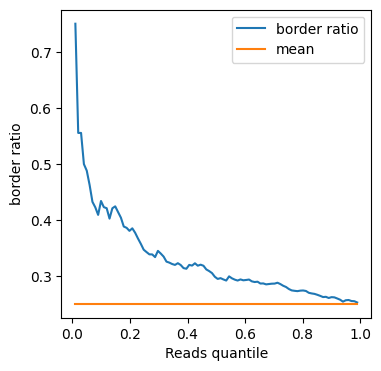

In [276]:
meta_data = "border"
prop = "Reads"
quant = lambda q: df[df[prop] < df[prop].quantile(q)][meta_data].mean()

#plot border ratio for different quantiles of OD
fig = plt.figure(figsize=(4, 4))
qs = np.linspace(0.01, 0.99, 100)
border_ratios = [quant(q) for q in qs]
plt.plot(qs, border_ratios)
#constant border ratio
plt.plot(qs, [df[meta_data].mean()] * len(qs))
plt.xlabel(f'{prop} quantile')
plt.ylabel(f'{meta_data} ratio')
plt.legend([f'{meta_data} ratio', 'mean'])


Text(0, 0.5, 'counts per mutant')

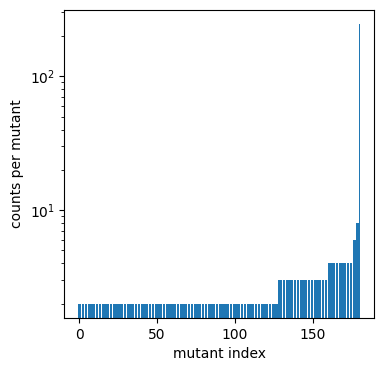

In [277]:
# sorted histogram of mutant counts
fig = plt.figure(figsize=(4, 4))
mutant_counts = df["mutant"].value_counts()
varcounts = mutant_counts[mutant_counts > 1].sort_values()
# x axis cumulated counts
plt.bar(np.arange(len(varcounts)), varcounts)

# log y axis
plt.yscale('log')

plt.xlabel('mutant index')
plt.ylabel('counts per mutant')

Text(0.5, 1.0, 'rel std Fitness_raw only WT')

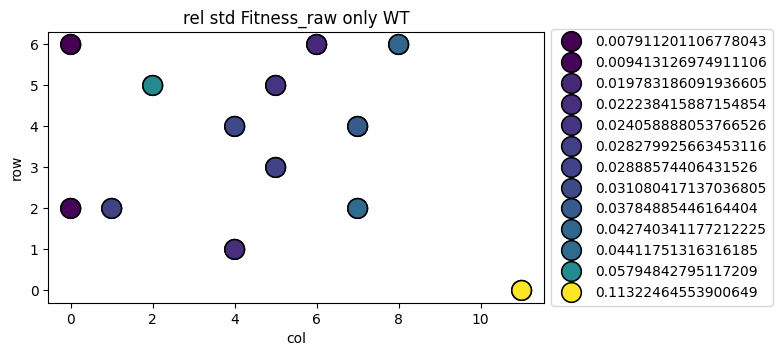

In [289]:
# df_wt = df[df["mutant"] == WT]
df_wt = df[df["mutant"] == WT]
df_wt = df_wt[df_wt["Plate"].isin([111, 112])]
# df_wt = 


agg = "std"
metric = "Fitness_raw"
rel = "rel"
# drop min and max Fitness values
# df_wt = df_wt[(df_wt[metric] > df_wt[metric].quantile(0.05)) & (df_wt[metric] < df_wt[metric].quantile(0.95))]

df_wt[agg] = df_wt.groupby(['row', 'col'])[metric].transform(agg)
if rel=="rel":
    df_wt[agg] = df_wt[agg] / df_wt.groupby(['row', 'col'])[metric].transform("mean")

sns.scatterplot(x='col', y='row', hue=agg, data=df_wt, s=200, edgecolor='black', legend="full", palette="viridis")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'{rel} {agg} {metric} only WT')
# df_wt.sort_values(by="Fitness", ascending=False)

<Axes: xlabel='border', ylabel='Fitness_raw'>

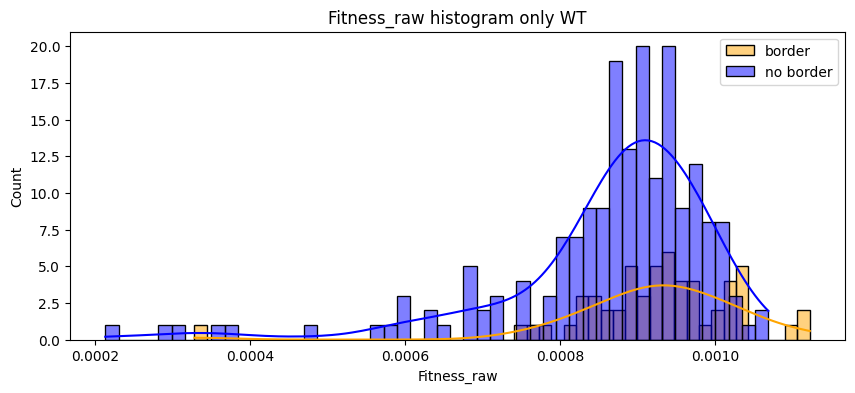

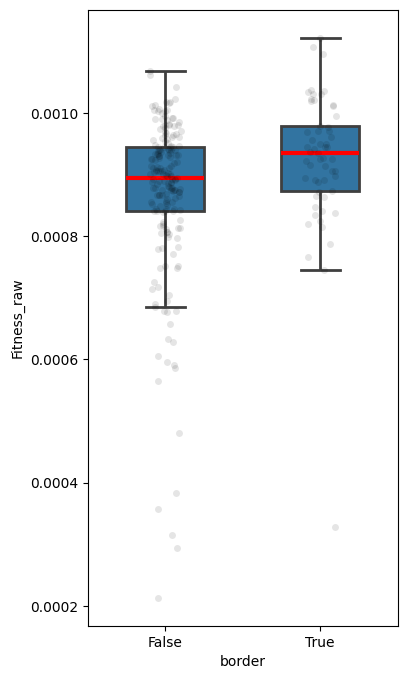

In [279]:

# df_wt = df[df["mutant"] == WT]
df_wt = df[df["mutant"] == WT]


agg = "std"
metric = "Fitness_raw"
rel = "rel"

#histogram of Fitness values for border true and false
fig = plt.figure(figsize=(10, 4))
# sns.histplot(df_wt[metric], bins=20, kde=True, label="all")
sns.histplot(df_wt[df_wt["border"]][metric], bins=50, kde=True, label="border", color="orange", alpha=0.5)
sns.histplot(df_wt[~df_wt["border"]][metric], bins=50, kde=True, label="no border", color="blue", alpha=0.5)
plt.legend()

plt.title(f'{metric} histogram only WT')

# scatter with hue border
fig = plt.figure(figsize=(4, 8))
# sns.violinplot(x='border', y=metric, data=df_wt)
sns.boxplot(x='border', y=metric, data=df_wt, showfliers=False, width=0.5, linewidth=2, medianprops={'color': 'red', 'linewidth': 3})
sns.stripplot(x='border', y=metric, data=df_wt, jitter=True, alpha=0.1, color='black')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

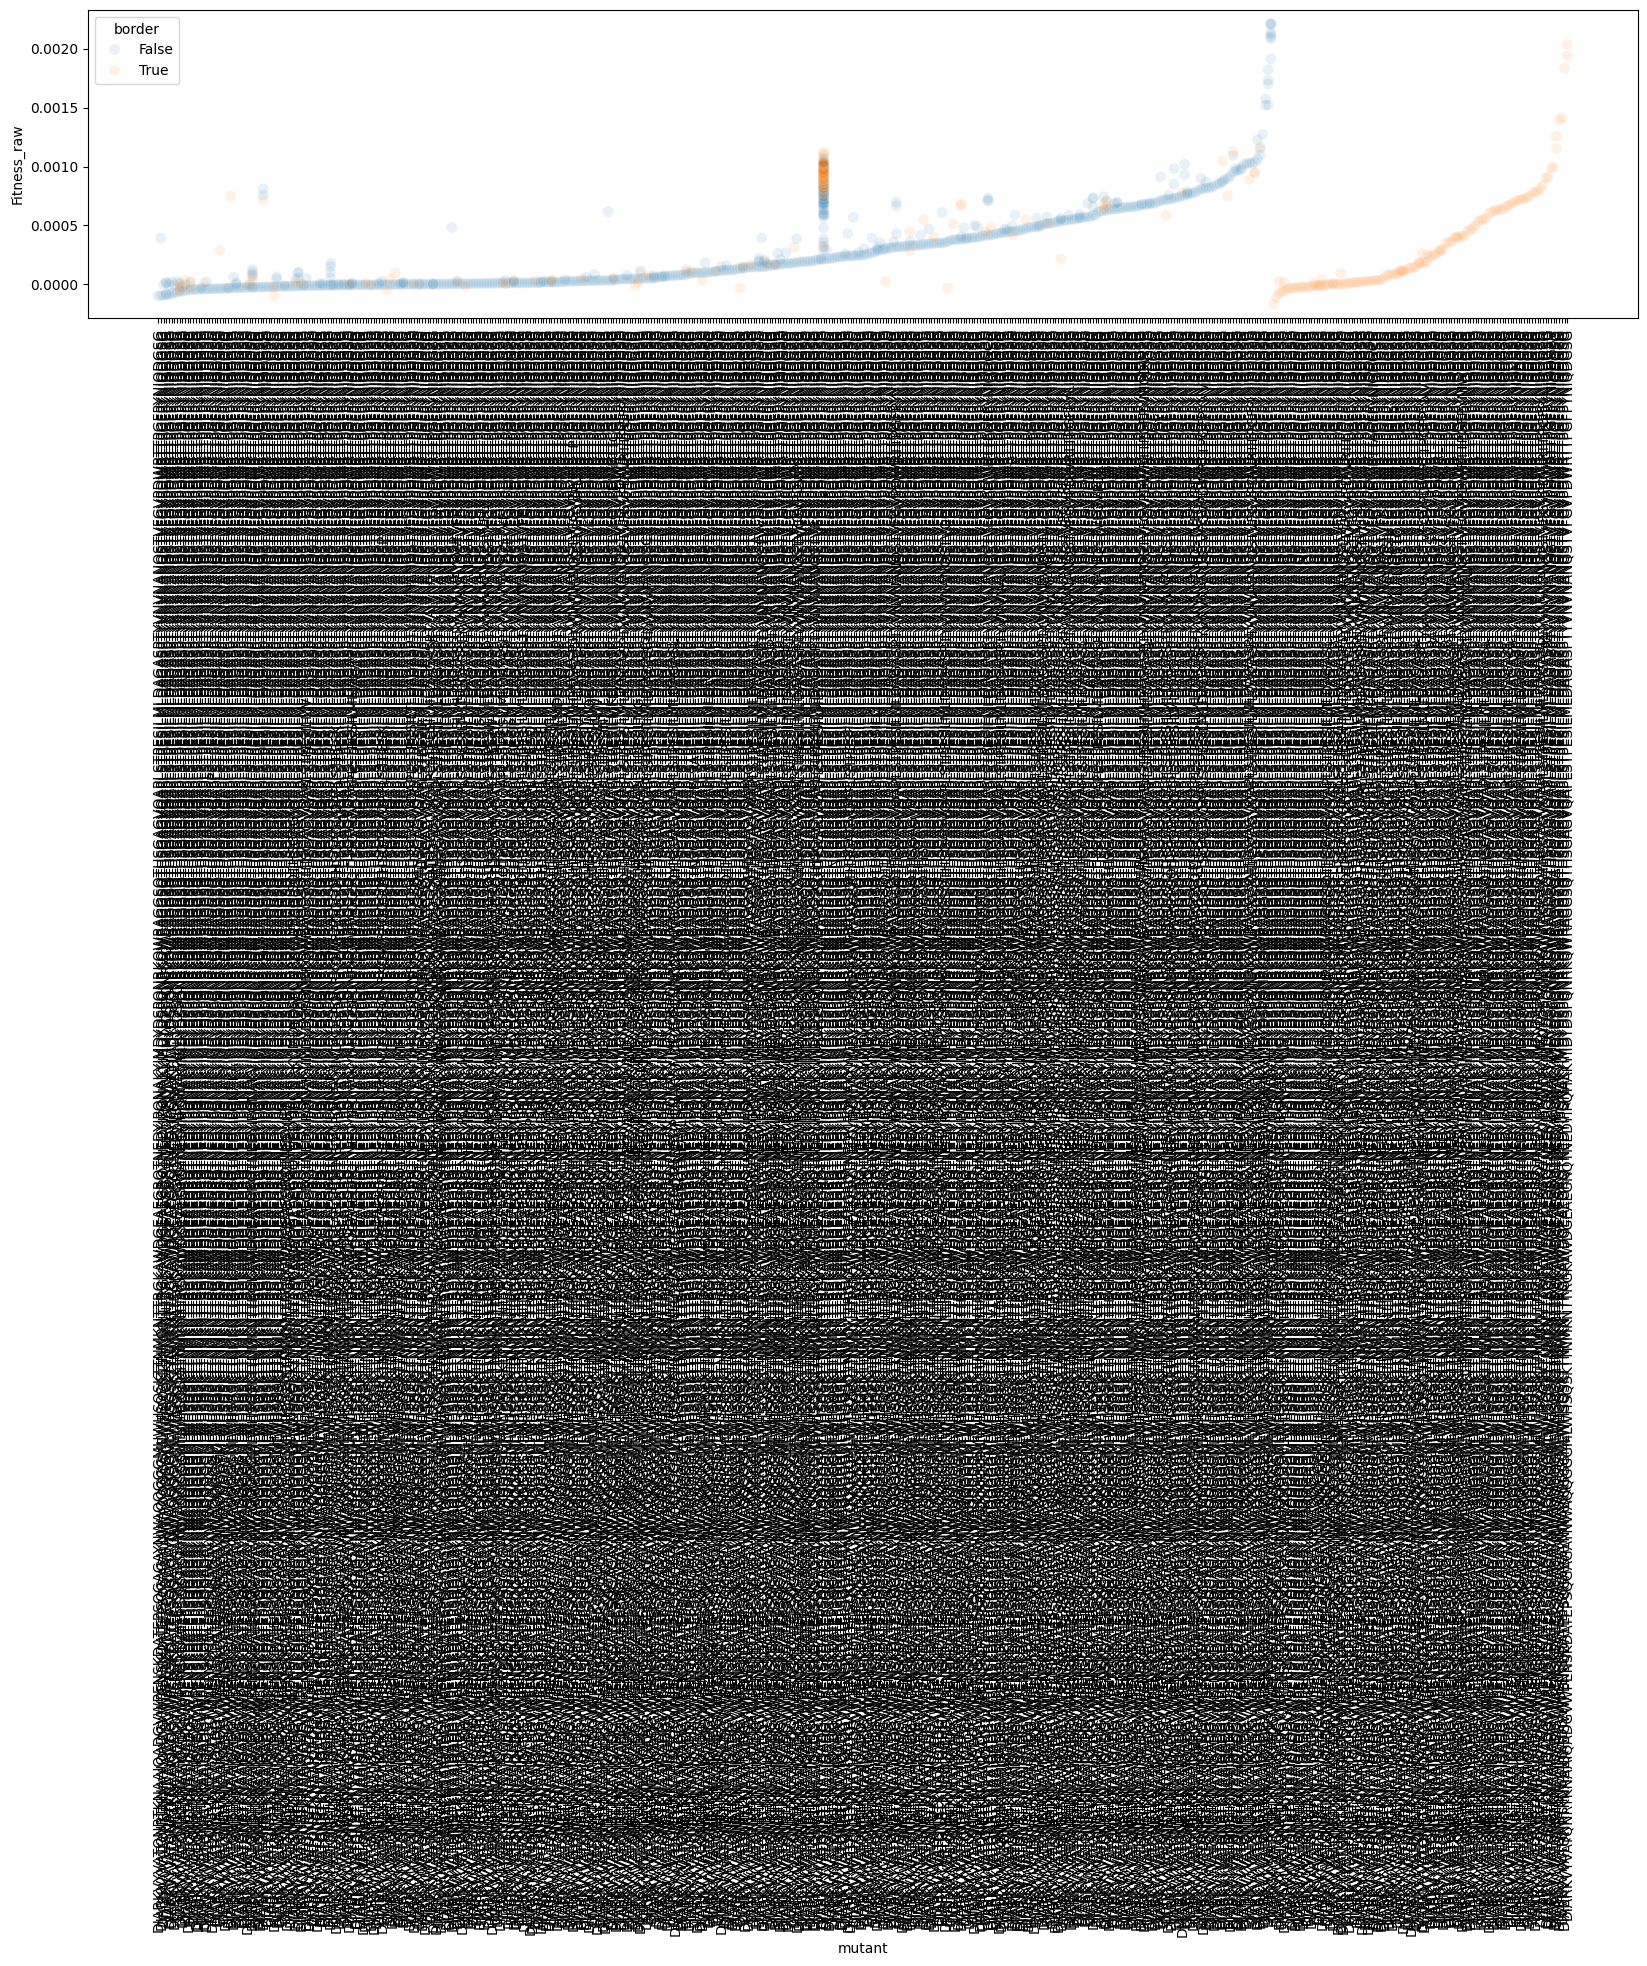

In [280]:
sus_df = df[df['mutant'].isin(df.groupby('mutant')['border'].mean().index)].sort_values(['border', 'Fitness_raw'])
fig = plt.figure(figsize=(20, 4))
sns.scatterplot(data=sus_df, x='mutant', y='Fitness_raw', hue='border', s=60, alpha=0.1)
plt.xticks(rotation=90)



C:\Users\queim\AppData\Local\Temp\ipykernel_13928\3216501900.py:10: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



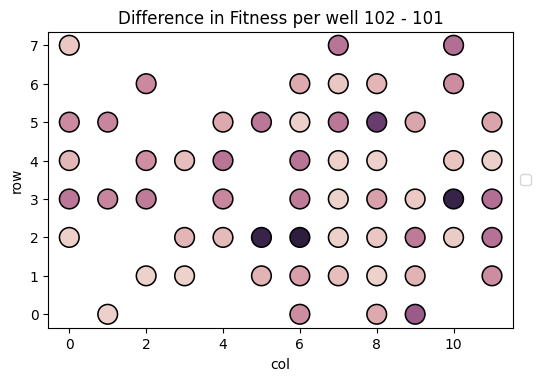

C:\Users\queim\AppData\Local\Temp\ipykernel_13928\3216501900.py:28: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



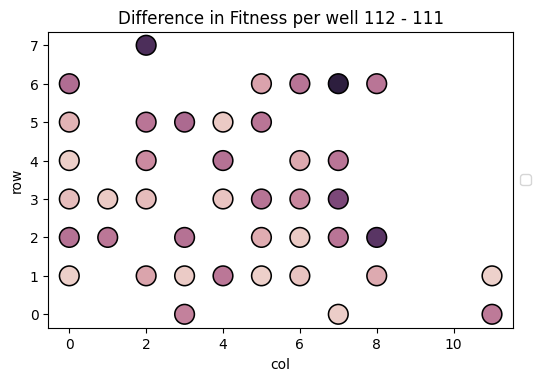

In [281]:

df111 = df[df["Plate"] == 101]
df112 = df[df["Plate"] == 102]

diff = df111.copy()
diff["Fitness"] = df112["Fitness"].values - df111["Fitness"]
diff['Fitness'] = diff['Fitness'].abs()

sns.scatterplot(x='col', y='row', hue=metric, data=diff, s=200, edgecolor='black', legend=False)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#title
plt.title('Difference in Fitness per well 102 - 101')
# bigger
plt.gcf().set_size_inches(6, 6)
plt.show()


# diff
df111 = df[df["Plate"] == 111]
df112 = df[df["Plate"] == 112]

diff = df111.copy()
diff["Fitness"] = df112["Fitness"].values - df111["Fitness"]
diff['Fitness'] = diff['Fitness'].abs()

sns.scatterplot(x='col', y='row', hue=metric, data=diff, s=200, edgecolor='black', legend=False)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#title
plt.title('Difference in Fitness per well 112 - 111')
# bigger
plt.gcf().set_size_inches(6, 6)
# diff


In [282]:
df112["Fitness"].values - df111["Fitness"]


658    0.023476
659    0.032877
660    0.116165
661   -0.000787
662    0.007924
663    0.030374
664   -0.010764
665    0.006841
666    0.026266
667   -0.052630
668   -0.015322
669   -0.056229
670   -0.002572
671   -0.025947
672    0.248462
673    0.094949
674    0.019779
675   -0.173149
676   -0.014765
677    0.001042
678   -0.000315
679   -0.025228
680   -0.001809
681   -0.022275
682   -0.013359
683   -0.008364
684   -0.043852
685    0.001335
686    0.004549
687    0.010951
688   -0.001631
689    0.039952
690    0.123526
691    0.046512
692   -0.008588
693   -0.057608
694    0.004277
695   -0.068335
696   -0.100544
697    0.017724
698    0.012814
Name: Fitness, dtype: float64

In [283]:
df["mutant"].apply(lambda x: len(x)).value_counts()

mutant
169    1034
Name: count, dtype: int64

In [284]:
df.columns

Index(['Fitness', 'Fitness_raw', 'Plate', 'Position', 'variant', 'Reads',
       'mutant', 'row', 'col', 'crow', 'ccol', 'dist', 'dist_c_row',
       'dist_c_col', 'border'],
      dtype='object')

In [285]:

# import pygwalker as pyg

# pyg.walk(df)

In [286]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

# Index(['Fitness', 'Fitness_raw', 'Plate', 'Position', 'variant', 'Reads', '10',
#        '45', '46', 'mutant', 'row', 'col', 'crow', 'ccol', 'dist',
#        'dist_c_row', 'dist_c_col', 'border'],
#       dtype='object')

df["row"] = df["row"].astype("category")
df["col"] = df["col"].astype("category")
df["dist"] = df["dist"].astype("category")

df["Plate"] = df["Plate"].astype("category")


fig = px.scatter_matrix(df,
    dimensions=["Fitness", "Fitness_raw", "Reads", "row", "col", "border"],
    color="Plate",
    # size="mean_norm_TSNAK",
    hover_data=["Plate", "Position", "Reads"],
    
    )

# make diaginal plots histograms


fig.update_layout(
    hoversubplots="axis",
    width=1000,
    height=1000,
    hovermode="closest",
    font=dict(
        size=6,
    )
)



#show in browser
fig.show()
# sns.pairplot(df_numeric)
# #correlation matrix
# corr = df_numeric.corr()
# # #render as table html
# corr.style.background_gradient(cmap='coolwarm')

In [287]:

import plotly.figure_factory as ff

import numpy as np
import pandas as pd
dataframe = df[["Fitness", "Fitness_raw", "Reads", "row", "col", "border", "Plate" ]]

fig = ff.create_scatterplotmatrix(dataframe, diag='histogram', index='Plate',
                                  height=800, width=800)


fig.show()
